## Verification and Bias testing 
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

*y_pred*: 25 member Ensemble Downscaled tasmean --> the 25 members are further feature reduced to one variable for verification and bias testing purpose

*y_true*: CERRA Tasmean for the given period

In [1]:
# define the predictand
PREDICTAND = 'tasmin'  # 'tasmin' or 'tasmax' or 'tasmean'
year = 2020

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'Downscaled SEAS5'
TRUE = f'CERRA_{PREDICTAND}'

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [4]:
if year == 2016:

    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_0mm_dem_doy_2016.nc")    

else:
    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_0mm_dem_doy_2020.nc")    

y_pred

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


<xarray.Dataset>
Dimensions:  (time: 366, number: 51, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * number   (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * y        (y) float64 43.62 43.69 43.75 43.82 43.89 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmin   (time, y, x, number) float64 ...

In [5]:
y_pred = y_pred - 273.15

In [6]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_2m_tasmin_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_2m_tasmax_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset>
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y                  (y) float64 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [7]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [8]:
y_true

<xarray.Dataset>
Dimensions:            (x: 161, y: 96, time: 366)
Coordinates:
  * x                  (x) float64 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y                  (y) float64 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2020-01-01 ... 2020-12-31
Data variables:
    tasmin             (time, y, x) float32 -1.463 -1.394 ... -2.921 -2.829
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
y_pred

<xarray.Dataset>
Dimensions:  (time: 366, number: 51, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * number   (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * y        (y) float64 43.62 43.69 43.75 43.82 43.89 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmin   (time, y, x, number) float64 -1.002 -0.6162 ... 3.406 -2.403

In [10]:
tasmean = y_pred[PREDICTAND].mean(dim='number')
y_pred = tasmean.to_dataset(name=PREDICTAND)


In [11]:
y_pred

<xarray.Dataset>
Dimensions:  (time: 366, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * y        (y) float64 43.62 43.69 43.75 43.82 43.89 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmin   (time, y, x) float64 -0.4757 -0.529 -0.7026 ... -2.915 -2.772

In [12]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2020
Ending year: 2020


In [13]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [14]:
y_true

<xarray.DataArray 'tasmin' (time: 366, y: 96, x: 161)>
array([[[-1.462738  , -1.3942871 , -1.1473999 , ..., 10.358459  ,
         10.4513855 , 10.33844   ],
        [-1.744873  , -1.4615784 , -1.2251587 , ...,  9.905304  ,
          9.80484   ,  8.996979  ],
        [-1.8055725 , -0.61816406, -0.46566772, ...,  8.995239  ,
          8.07077   ,  7.466522  ],
        ...,
        [-0.7977295 , -0.7911682 , -0.86727905, ..., -2.9801025 ,
         -2.6887207 , -2.5838318 ],
        [-0.7293701 , -0.64575195, -0.8249512 , ..., -2.3204346 ,
         -2.4190063 , -2.673523  ],
        [-0.41275024, -0.30871582, -0.5402527 , ..., -2.4858398 ,
         -2.4140625 , -2.4091797 ]],

       [[-0.7579346 , -0.22045898, -0.34942627, ...,  8.654846  ,
          9.023071  ,  8.843506  ],
        [-1.1061096 , -0.66400146, -0.6142273 , ...,  7.400238  ,
          7.446533  ,  5.469055  ],
        [-0.830719  , -0.32125854, -0.47406006, ...,  6.4643555 ,
          5.2055664 ,  3.5256958 ],
...
        [-0.03863525, -0.10525513, -0.18927002, ..., -1.5263062 ,
         -1.394104  , -1.2609253 ],
        [ 0.03869629,  0.04748535, -0.09616089, ..., -0.8831482 ,
         -0.8088684 , -0.6906738 ],
        [ 0.54751587,  0.5684509 ,  0.29696655, ..., -1.0719604 ,
         -0.9185486 , -1.3816528 ]],

       [[-2.1878967 , -2.3990173 , -2.630951  , ...,  8.75946   ,
          8.909149  ,  8.823059  ],
        [-2.1674194 , -2.4900513 , -2.457428  , ...,  8.241241  ,
          8.3905945 ,  7.9864807 ],
        [-2.1190186 , -2.5741882 , -2.6878052 , ...,  8.166748  ,
          7.0091248 ,  6.0894775 ],
        ...,
        [-0.25308228, -0.20223999, -0.2864685 , ..., -2.1756287 ,
         -2.2763672 , -2.2533875 ],
        [-0.20050049, -0.10928345, -0.27352905, ..., -2.3085022 ,
         -2.591095  , -2.8066406 ],
        [ 0.08630371,  0.12783813, -0.12850952, ..., -2.993164  ,
         -2.920868  , -2.8287659 ]]], dtype=float32)
Coordinates:
  * x                  (x) float64 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y                  (y) float64 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2020-01-01 ... 2020-12-31

In [15]:
y_pred

<xarray.DataArray 'tasmin' (time: 366, y: 96, x: 161)>
array([[[-4.75666021e-01, -5.28959681e-01, -7.02612631e-01, ...,
          8.63964023e+00,  8.37429736e+00,  8.17210686e+00],
        [-7.00235180e-01, -8.76351929e-01, -5.68494570e-01, ...,
          6.86873713e+00,  7.13077403e+00,  5.60143581e+00],
        [-7.56353541e-01,  2.61977006e-01,  4.68448202e-01, ...,
          6.59933677e+00,  4.69883338e+00,  4.02658545e+00],
        ...,
        [-2.30473487e+00, -2.03403635e+00, -2.20581052e+00, ...,
         -1.74488216e+00, -1.05474996e+00, -6.58436640e-01],
        [-1.75304275e+00, -1.50691354e+00, -1.91411487e+00, ...,
         -3.54739012e-03, -5.04934959e-01, -9.98097328e-01],
        [-1.42658268e+00, -1.65675635e+00, -1.45162333e+00, ...,
         -9.59271182e-01, -8.41350457e-01, -1.05613025e+00]],

       [[ 2.69495595e-01,  1.63636565e-01,  1.29885958e-01, ...,
          7.73236201e+00,  8.05008608e+00,  7.69772363e+00],
        [-7.11589189e-02,  1.06124946e-01, -7.21241126e-02, ...,
          5.71095821e+00,  6.20676722e+00,  3.93403988e+00],
        [ 2.96318233e-02,  4.96266752e-01,  4.92102364e-01, ...,
          5.02313935e+00,  2.71274935e+00,  1.76786748e+00],
...
        [-5.11207661e-02, -7.96253701e-02, -5.74651367e-02, ...,
         -3.14675776e+00, -3.15637436e+00, -2.80916565e+00],
        [-6.03345731e-02,  1.21500286e-01,  1.11045105e-02, ...,
         -2.70382593e+00, -2.60098591e+00, -2.48473458e+00],
        [ 2.43091836e-01,  2.01263834e-01,  1.45265873e-01, ...,
         -2.67204877e+00, -2.63753546e+00, -2.47265365e+00]],

       [[ 1.94138083e+00,  1.57336072e+00,  1.22767980e+00, ...,
          8.77384790e+00,  8.92230488e+00,  8.93776262e+00],
        [ 1.73766962e+00,  1.21831709e+00,  1.07889645e+00, ...,
          7.31352449e+00,  7.22056540e+00,  6.34440958e+00],
        [ 1.67112426e+00,  1.43566783e+00,  1.19432814e+00, ...,
          6.35271355e+00,  4.94065062e+00,  4.40800275e+00],
        ...,
        [-2.55659567e-01, -3.11598159e-01, -2.30662837e-01, ...,
         -3.58723270e+00, -3.46745450e+00, -3.29066025e+00],
        [-2.59018721e-01, -7.24668002e-02, -2.85837049e-01, ...,
         -3.10209053e+00, -3.01708591e+00, -2.86383290e+00],
        [ 1.20071459e-02,  4.42740548e-02, -4.76749208e-02, ...,
         -2.88635546e+00, -2.91530241e+00, -2.77199383e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * y        (y) float64 43.62 43.69 43.75 43.82 43.89 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82

In [16]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [17]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [18]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

In [19]:
y_pred_anom

<xarray.DataArray 'tasmin' (time: 366, y: 96, x: 161)>
array([[[-2.92228219e+00, -2.66208849e+00, -2.53490770e+00, ...,
          7.97340884e-01,  3.58265699e-01,  2.77751569e-01],
        [-2.92650517e+00, -2.57360076e+00, -2.13854766e+00, ...,
          6.79087323e-01,  8.89976141e-01,  6.69938668e-01],
        [-2.83384954e+00, -1.66958633e+00, -1.29914148e+00, ...,
          1.36093774e+00,  1.05013403e+00,  1.18891973e+00],
        ...,
        [-2.37352137e+00, -2.10025640e+00, -2.23663303e+00, ...,
          7.39404793e-01,  1.26718740e+00,  1.38563821e+00],
        [-1.91199833e+00, -1.79499587e+00, -2.08941617e+00, ...,
          1.84548040e+00,  1.22735027e+00,  7.43311762e-01],
        [-1.77724412e+00, -2.07708217e+00, -1.83214640e+00, ...,
          8.29280879e-01,  9.33825486e-01,  8.04783900e-01]],

       [[-2.17712058e+00, -1.96949225e+00, -1.70240911e+00, ...,
         -1.09937342e-01,  3.40544231e-02, -1.96631657e-01],
        [-2.29742891e+00, -1.59112388e+00, -1.64217720e+00, ...,
         -4.78691591e-01, -3.40306695e-02, -9.97457255e-01],
        [-2.04786418e+00, -1.43529659e+00, -1.27548732e+00, ...,
         -2.15259687e-01, -9.35950000e-01, -1.06979825e+00],
...
        [ 4.75531135e-01,  4.73490545e-01,  4.73620474e-01, ...,
         -1.06190318e+00, -1.19009699e+00, -1.09321895e+00],
        [ 4.59986009e-01,  5.22201108e-01,  5.14157262e-01, ...,
         -1.07862728e+00, -1.09990447e+00, -1.11376201e+00],
        [ 5.62003435e-01,  4.65923530e-01,  5.03341171e-01, ...,
         -1.25061656e+00, -1.24965148e+00, -1.17651248e+00]],

       [[-2.29421684e-01, -2.64749439e-01, -2.91651351e-01, ...,
         -1.28300293e+00, -1.28700870e+00, -1.23210789e+00],
        [-1.16334561e-01, -1.99449039e-01, -1.92524046e-01, ...,
         -1.39473041e+00, -1.51395772e+00, -1.51801395e+00],
        [-1.28446793e-01, -7.64382124e-02, -1.32423229e-01, ...,
         -1.45926368e+00, -1.69169992e+00, -1.65145744e+00],
        ...,
        [ 2.70992334e-01,  2.41517755e-01,  3.00422773e-01, ...,
         -1.50237813e+00, -1.50117713e+00, -1.57471355e+00],
        [ 2.61301861e-01,  3.28234021e-01,  2.17215702e-01, ...,
         -1.47689188e+00, -1.51600448e+00, -1.49286033e+00],
        [ 3.30918745e-01,  3.08933751e-01,  3.10400377e-01, ...,
         -1.46492324e+00, -1.52741842e+00, -1.47585266e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * y        (y) float64 43.62 43.69 43.75 43.82 43.89 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82

In [20]:
y_true_anom

<xarray.DataArray 'tasmin' (time: 366, y: 96, x: 161)>
array([[[-5.65087700e+00, -5.48954439e+00, -5.13509560e+00, ...,
          1.20591164e+00,  8.51079941e-01,  9.54868317e-01],
        [-5.58579969e+00, -5.02450943e+00, -4.63696384e+00, ...,
          2.31551647e+00,  2.04249144e+00,  2.82387400e+00],
        [-5.38339806e+00, -4.22298908e+00, -3.86007094e+00, ...,
          2.36741018e+00,  2.90376997e+00,  3.41046810e+00],
        ...,
        [-2.61470962e+00, -2.56952786e+00, -2.59425783e+00, ...,
         -9.07598734e-01, -7.95819640e-01, -9.71545815e-01],
        [-2.58090019e+00, -2.51166964e+00, -2.61164021e+00, ...,
         -1.09789550e+00, -1.33336413e+00, -1.67366576e+00],
        [-2.48809409e+00, -2.44809842e+00, -2.55480361e+00, ...,
         -1.50164604e+00, -1.49102783e+00, -1.46221828e+00]],

       [[-4.94607353e+00, -4.31571627e+00, -4.33712196e+00, ...,
         -4.97701645e-01, -5.77234268e-01, -5.40065765e-01],
        [-4.94703627e+00, -4.22693253e+00, -4.02603245e+00, ...,
         -1.89549446e-01, -3.15815449e-01, -7.04049587e-01],
        [-4.40854454e+00, -3.92608356e+00, -3.86846328e+00, ...,
         -1.63473606e-01,  3.85661125e-02, -5.30358315e-01],
...
         -2.08938003e+00, -2.08909559e+00, -2.18716717e+00],
        [-2.22707152e+00, -2.24709892e+00, -2.25461507e+00, ...,
         -2.12470269e+00, -2.20914388e+00, -2.20460558e+00],
        [-1.98552966e+00, -2.02561402e+00, -2.12778115e+00, ...,
         -2.72087932e+00, -2.63546562e+00, -3.10095119e+00]],

       [[-6.28303766e+00, -6.27453423e+00, -6.22300053e+00, ...,
         -2.42419815e+00, -2.71896267e+00, -2.58722210e+00],
        [-5.98303223e+00, -5.99205685e+00, -5.78089428e+00, ...,
         -1.63172626e+00, -1.72934151e+00, -1.09506893e+00],
        [-5.94293976e+00, -6.09322834e+00, -5.92251968e+00, ...,
         -1.10039043e+00, -1.23192787e+00, -1.38977242e+00],
        ...,
        [-2.43888521e+00, -2.37177801e+00, -2.36580920e+00, ...,
         -2.73870254e+00, -2.97135878e+00, -3.17962933e+00],
        [-2.46626830e+00, -2.40386772e+00, -2.43198323e+00, ...,
         -3.55005670e+00, -3.99137044e+00, -4.32057238e+00],
        [-2.44674182e+00, -2.46622682e+00, -2.55325723e+00, ...,
         -4.64208317e+00, -4.63778496e+00, -4.54806423e+00]]],
      dtype=float32)
Coordinates:
  * x                  (x) float64 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y                  (y) float64 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
    heightAboveGround  float64 2.0
  * time               (time) datetime64[ns] 2020-01-01 ... 2020-12-31

### Coefficient of determination

In [21]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.96
R2 on daily anomalies: 0.27


### Coefficient of determination: Spatially

In [22]:
# iterate over the grid points
r2 = np.ones((2,  len(y_pred.y), len(y_pred.x)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, j, i] = r2_score(point_true, point_pred)
        r2[1, j, i] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_365485/2899518242.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_365485/2899518242.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


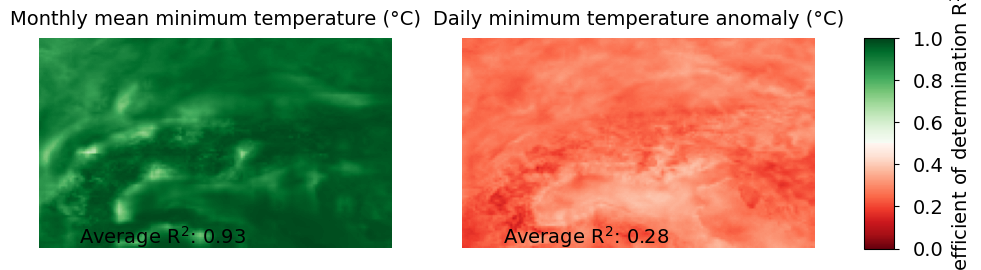

In [23]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = 0, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [24]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average bias of tasmin: -0.67°C


In [25]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average MAE of tasmin: 0.71°C


In [26]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average RMSE of tasmin: 0.91°C


In [27]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(2020): 0.99
Yearly average Pearson correlation coefficient for tasmin: 0.99


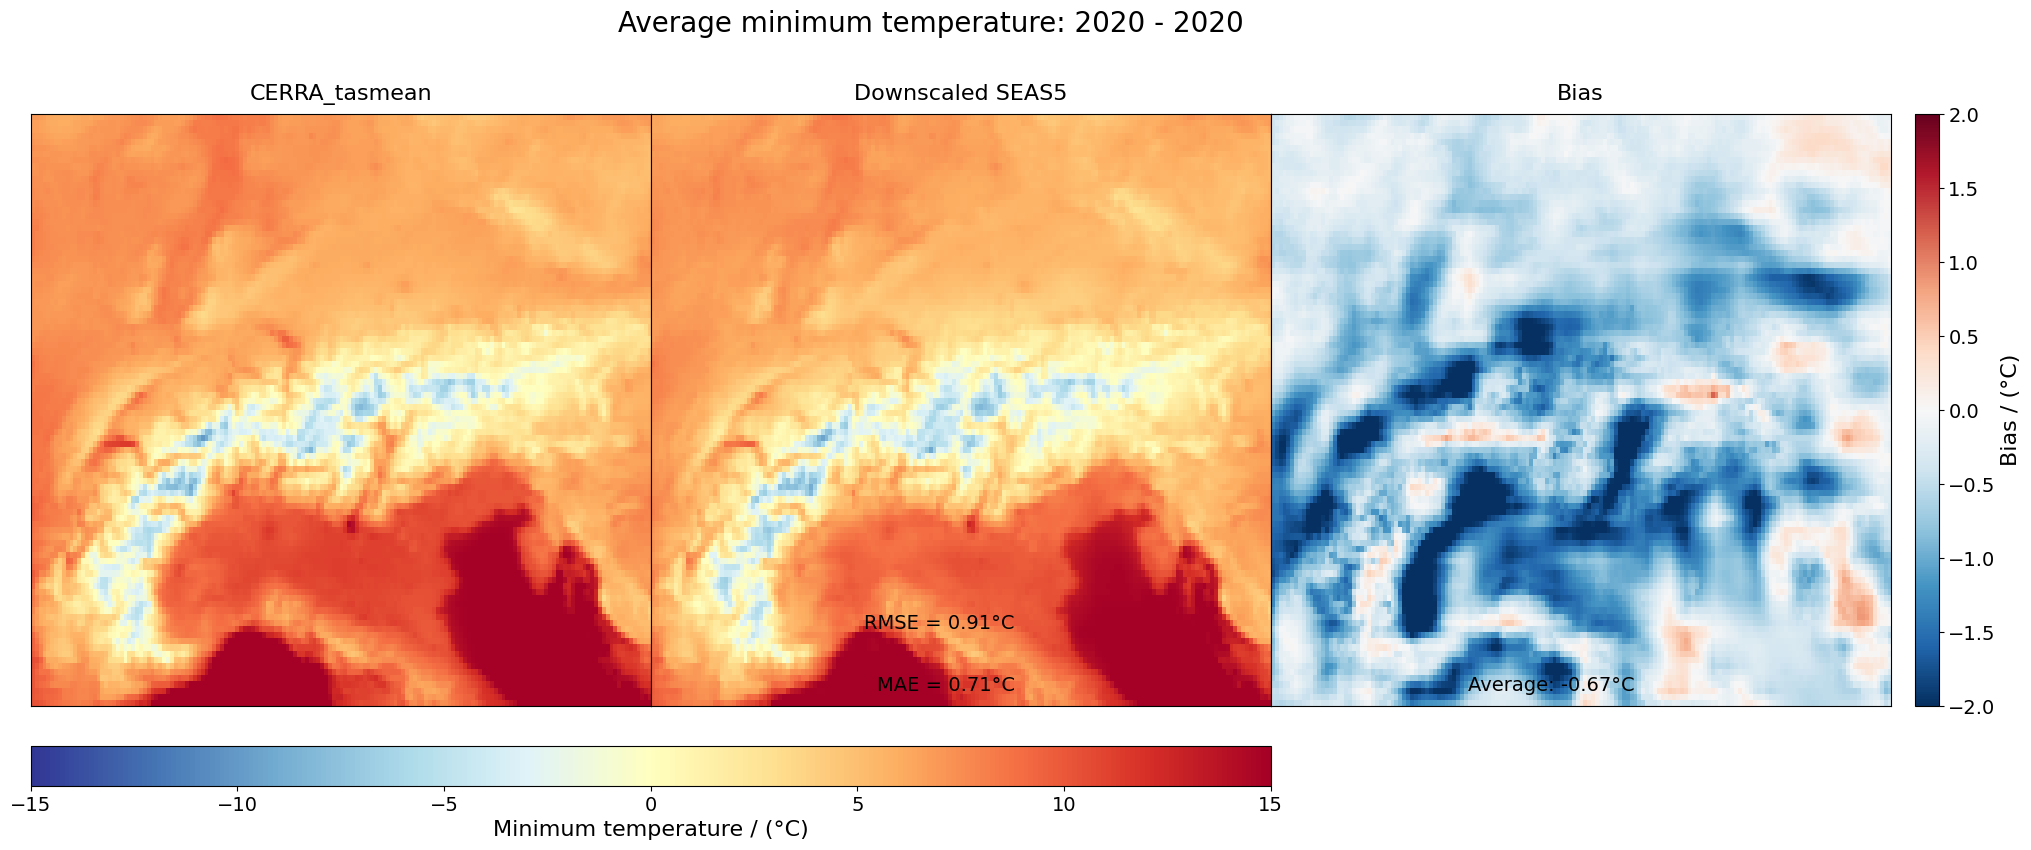

In [28]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='lower', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [29]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [30]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmin for season DJF: -1.8°C
(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmin for season JJA: 0.2°C
(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmin for season MAM: -0.6°C
(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmin for season SON: -0.6°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

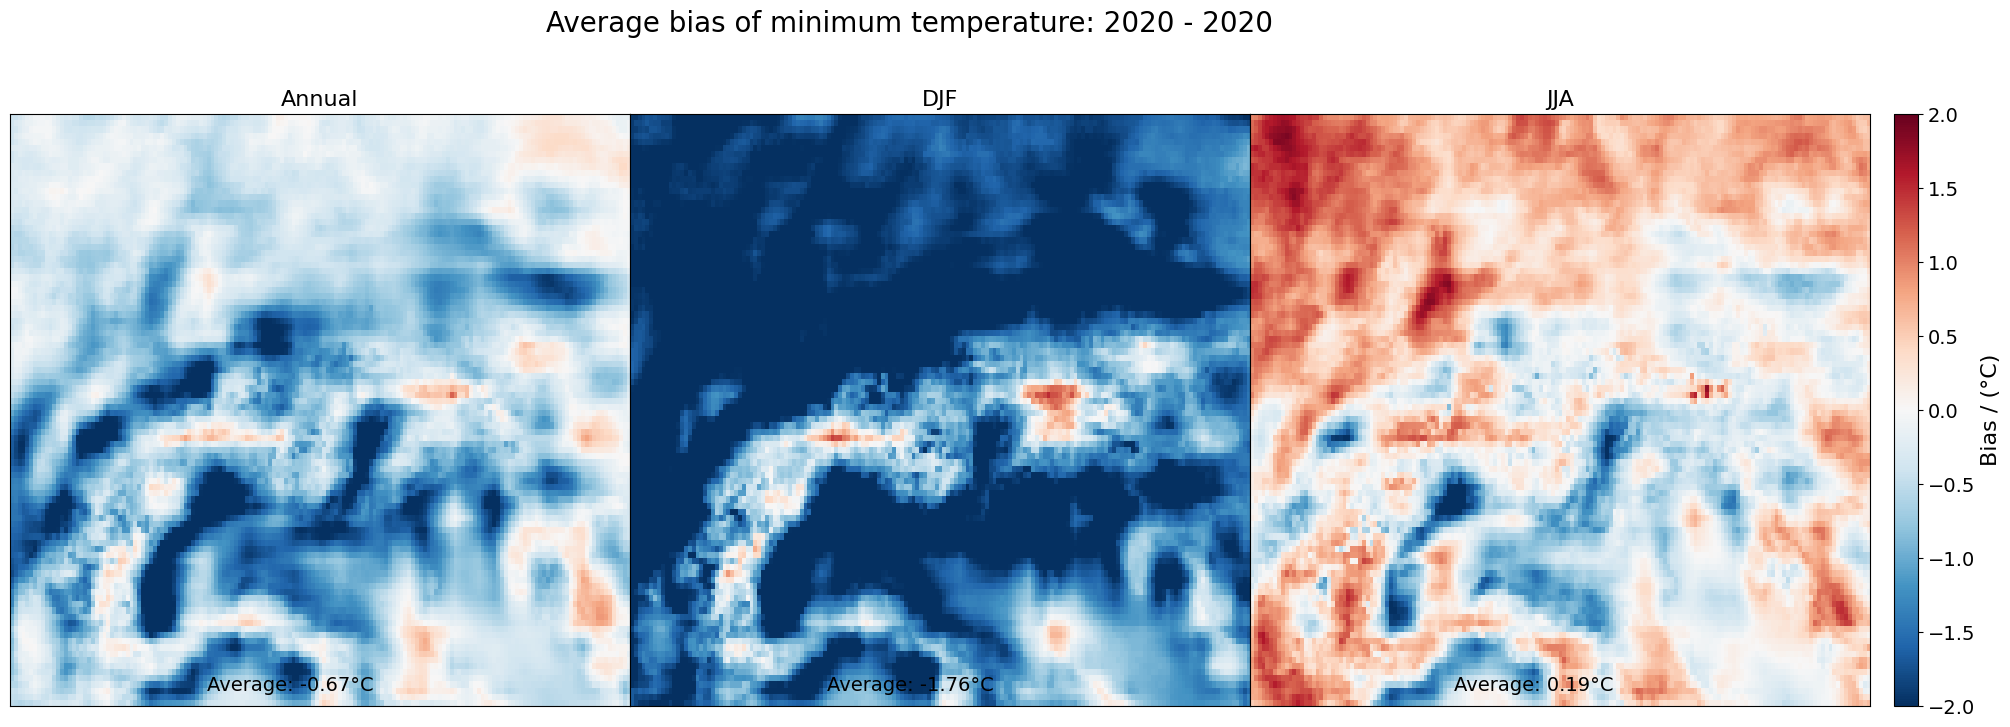

In [31]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
im = axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Bias / (°C)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [32]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [33]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [34]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [35]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average bias for P2 of tasmin: 0.7°C


In [36]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [37]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average MAE for P2 of tasmin: 1.0°C


In [38]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [39]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average RMSE for P2 of tasmin: 1.2°C


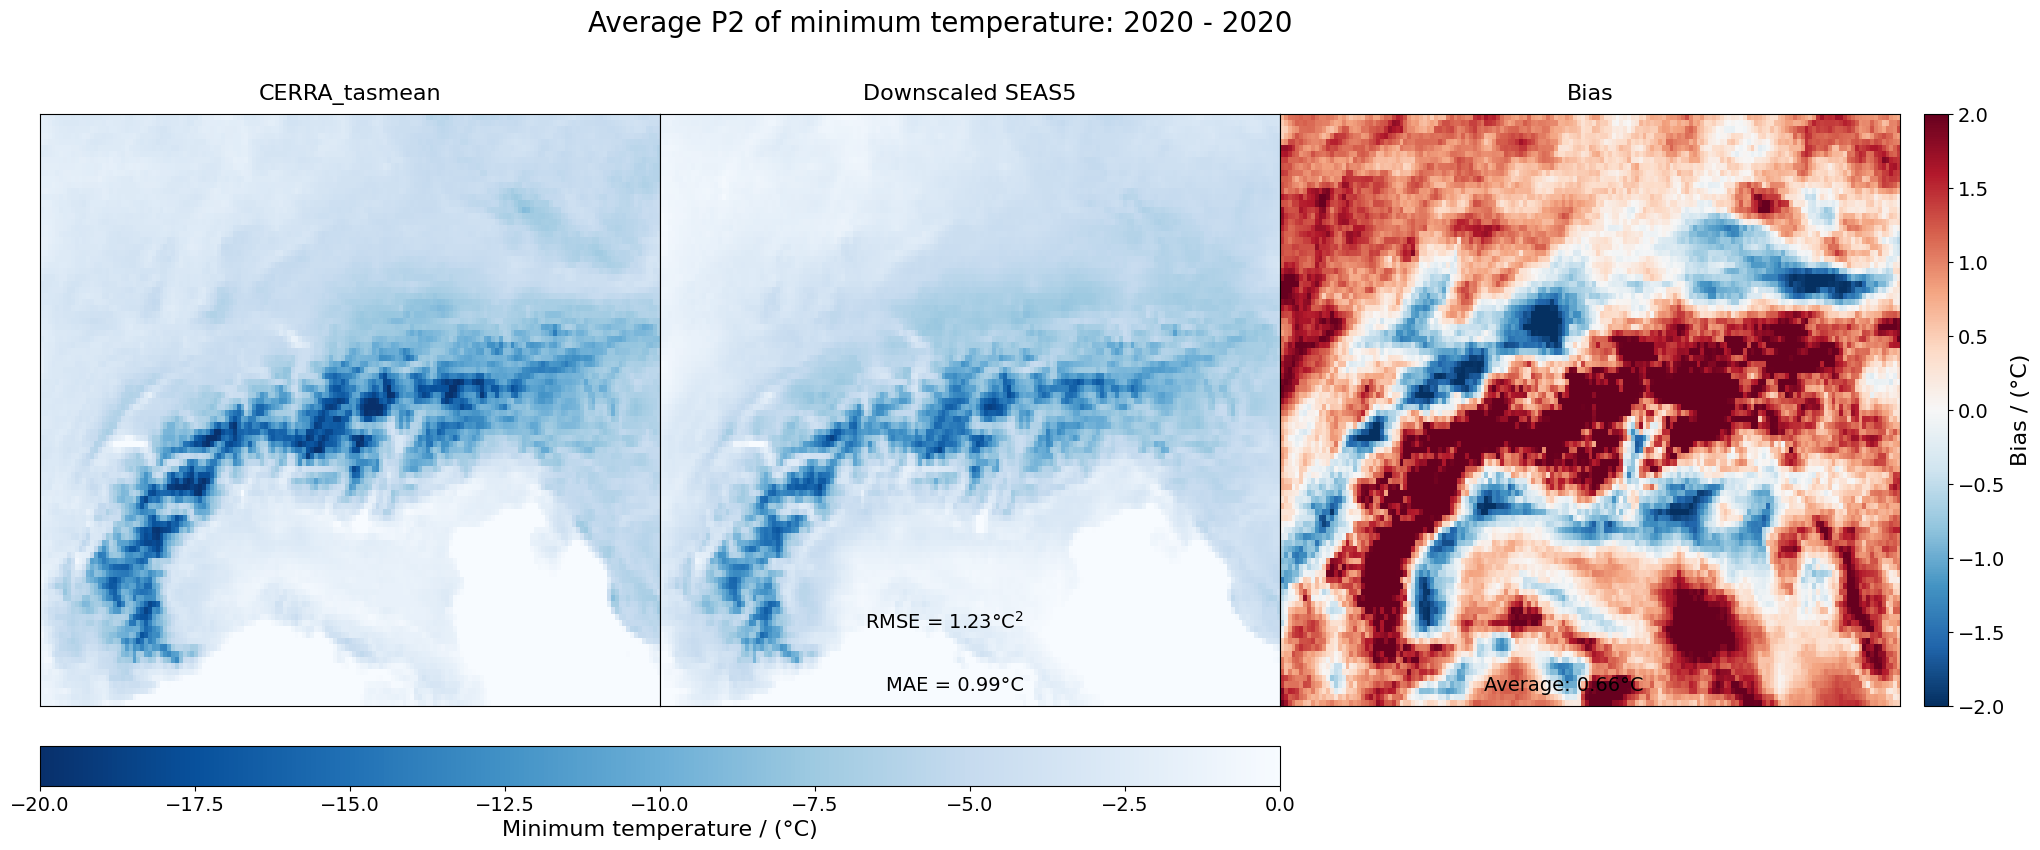

In [40]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='lower', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

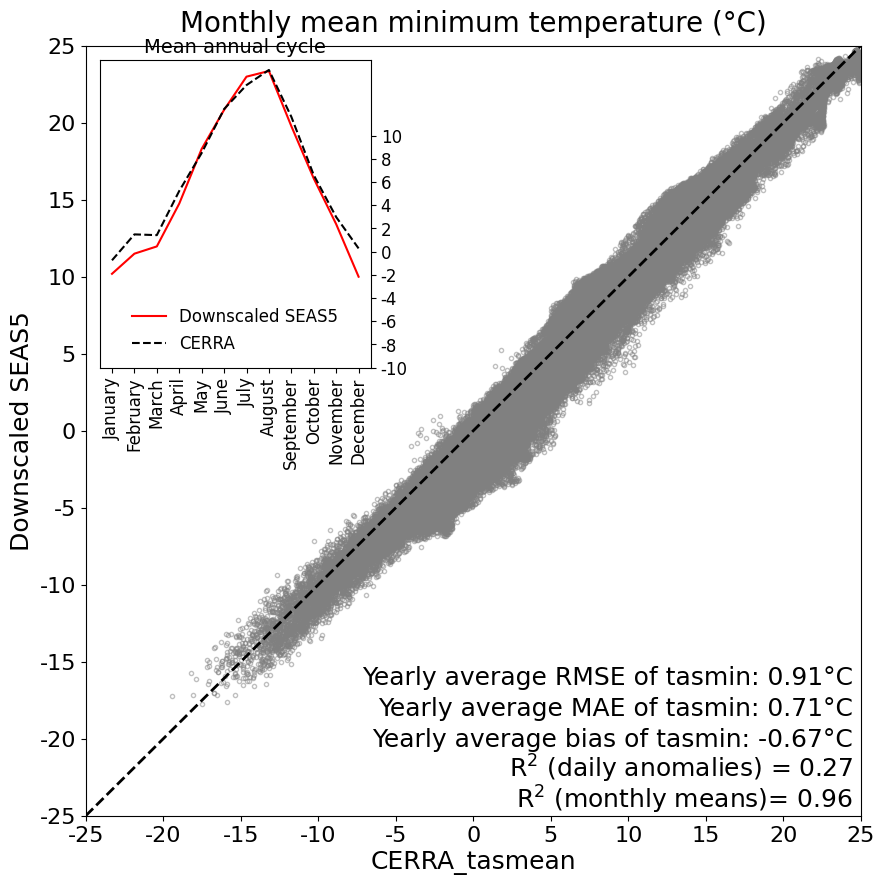

In [41]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA_tasmean', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='CERRA')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('mslp.png', dpi=300, bbox_inches='tight')
